In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers

# Sequential

In [20]:
# Define Sequential model with 3 layers
model = keras.Sequential(
    [
        layers.Dense(2, activation="relu", name="layer1", input_shape=(1,)),
        layers.Dense(3, activation="relu", name="layer2"),
        layers.Dense(4, name="layer3"),
    ]
)

In [18]:
# Ou ...
# Create 3 layers
layer1 = layers.Dense(2, activation="relu", name="layer1", input_shape=(1,))
layer2 = layers.Dense(3, activation="relu", name="layer2")
layer3 = layers.Dense(4, name="layer3")

model = keras.Sequential([layer1, layer2, layer3])

In [16]:
# Ou ... 
model = keras.Sequential(name="my_sequential")
model.add(layers.Dense(2, activation="relu", name="layer1", input_shape=(1,)))
model.add(layers.Dense(3, activation="relu", name="layer2"))
model.add(layers.Dense(4, name="layer3"))

In [21]:
# Sempre verifique o shape dos inputs e outputs
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 2)                 4         
_________________________________________________________________
layer2 (Dense)               (None, 3)                 9         
_________________________________________________________________
layer3 (Dense)               (None, 4)                 16        
Total params: 29
Trainable params: 29
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.layers

In [ ]:
# Using Transfer Learning from Hub
classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

# Functional

In [ ]:
(input: 784-dimensional vectors)
       ↧
[Dense (64 units, relu activation)]
       ↧
[Dense (64 units, relu activation)]
       ↧
[Dense (10 units, softmax activation)]
       ↧
(output: logits of a probability distribution over 10 classes)

In [2]:
inputs = keras.Input(shape=(784,))

In [3]:
# Just for demonstration purposes.
# img_inputs = keras.Input(shape=(32, 32, 3))

In [4]:
dense = layers.Dense(64, activation="relu")
x = dense(inputs)

In [5]:
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(10)(x)

In [6]:
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")

In [7]:
model.summary()

Model: "mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


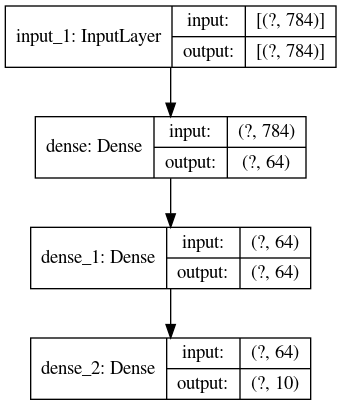

In [9]:
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

#### Use the same graph of layers to define multiple models

In [ ]:
encoder_input = keras.Input(shape=(28, 28, 1), name="img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

x = layers.Reshape((4, 4, 1))(encoder_output)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

autoencoder = keras.Model(encoder_input, decoder_output, name="autoencoder")
autoencoder.summary()

![](https://camo.githubusercontent.com/30637207970e68df69f1b9896acbda043940d992/68747470733a2f2f70702e757365726170692e636f6d2f633835343432302f763835343432303737342f39373332662f374a65465a6e5a612d586f2e6a7067)

#### Manipulate complex graph topologies

The functional API makes it easy to manipulate multiple inputs and outputs. This cannot be handled with the Sequential API.

For example, if you're building a system for ranking custom issue tickets by priority and routing them to the correct department, then the model will have three inputs:

the title of the ticket (text input),
the text body of the ticket (text input), and
any tags added by the user (categorical input)
This model will have two outputs:

the priority score between 0 and 1 (scalar sigmoid output), and
the department that should handle the ticket (softmax output over the set of departments).

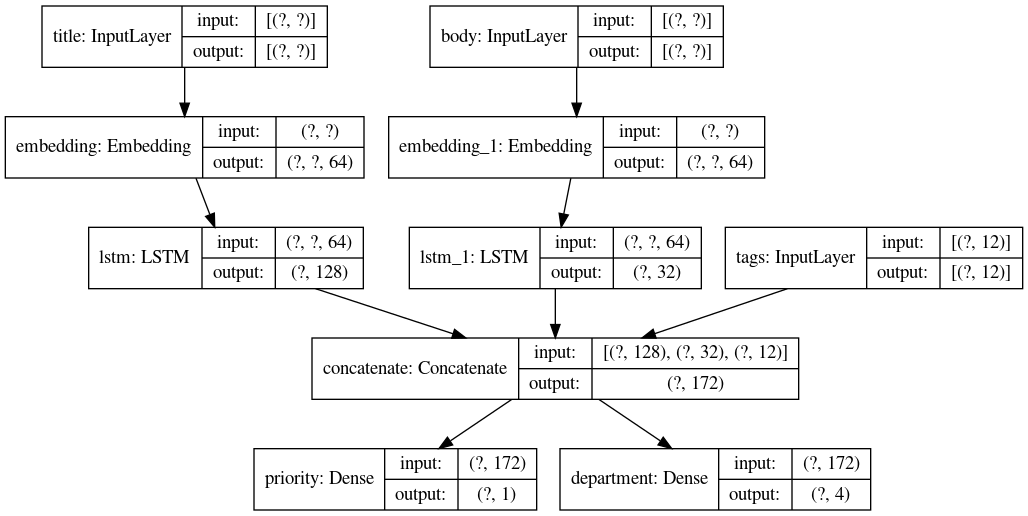

In [10]:
num_tags = 12  # Number of unique issue tags
num_words = 10000  # Size of vocabulary obtained when preprocessing text data
num_departments = 4  # Number of departments for predictions

title_input = keras.Input(
    shape=(None,), name="title"
)  # Variable-length sequence of ints
body_input = keras.Input(shape=(None,), name="body")  # Variable-length sequence of ints
tags_input = keras.Input(
    shape=(num_tags,), name="tags"
)  # Binary vectors of size `num_tags`

# Embed each word in the title into a 64-dimensional vector
title_features = layers.Embedding(num_words, 64)(title_input)
# Embed each word in the text into a 64-dimensional vector
body_features = layers.Embedding(num_words, 64)(body_input)

# Reduce sequence of embedded words in the title into a single 128-dimensional vector
title_features = layers.LSTM(128)(title_features)
# Reduce sequence of embedded words in the body into a single 32-dimensional vector
body_features = layers.LSTM(32)(body_features)

# Merge all available features into a single large vector via concatenation
x = layers.concatenate([title_features, body_features, tags_input])

# Stick a logistic regression for priority prediction on top of the features
priority_pred = layers.Dense(1, name="priority")(x)
# Stick a department classifier on top of the features
department_pred = layers.Dense(num_departments, name="department")(x)

# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(
    inputs=[title_input, body_input, tags_input],
    outputs=[priority_pred, department_pred],
)

keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [ ]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "priority": keras.losses.BinaryCrossentropy(from_logits=True),
        "department": keras.losses.CategoricalCrossentropy(from_logits=True),
    },
    loss_weights=[1.0, 0.2],
)

In [12]:
inputs = keras.Input(shape=(32, 32, 3), name="img")
x = layers.Conv2D(32, 3, activation="relu")(inputs)
x = layers.Conv2D(64, 3, activation="relu")(x)
block_1_output = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_2_output = layers.add([x, block_1_output])

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_3_output = layers.add([x, block_2_output])

x = layers.Conv2D(64, 3, activation="relu")(block_3_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10)(x)

model = keras.Model(inputs, outputs, name="toy_resnet")
model.summary()

Model: "toy_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 30, 30, 32)   896         img[0][0]                        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 9, 9, 64)     0           conv2d_1[0][0]                   
_________________________________________________________________________________________

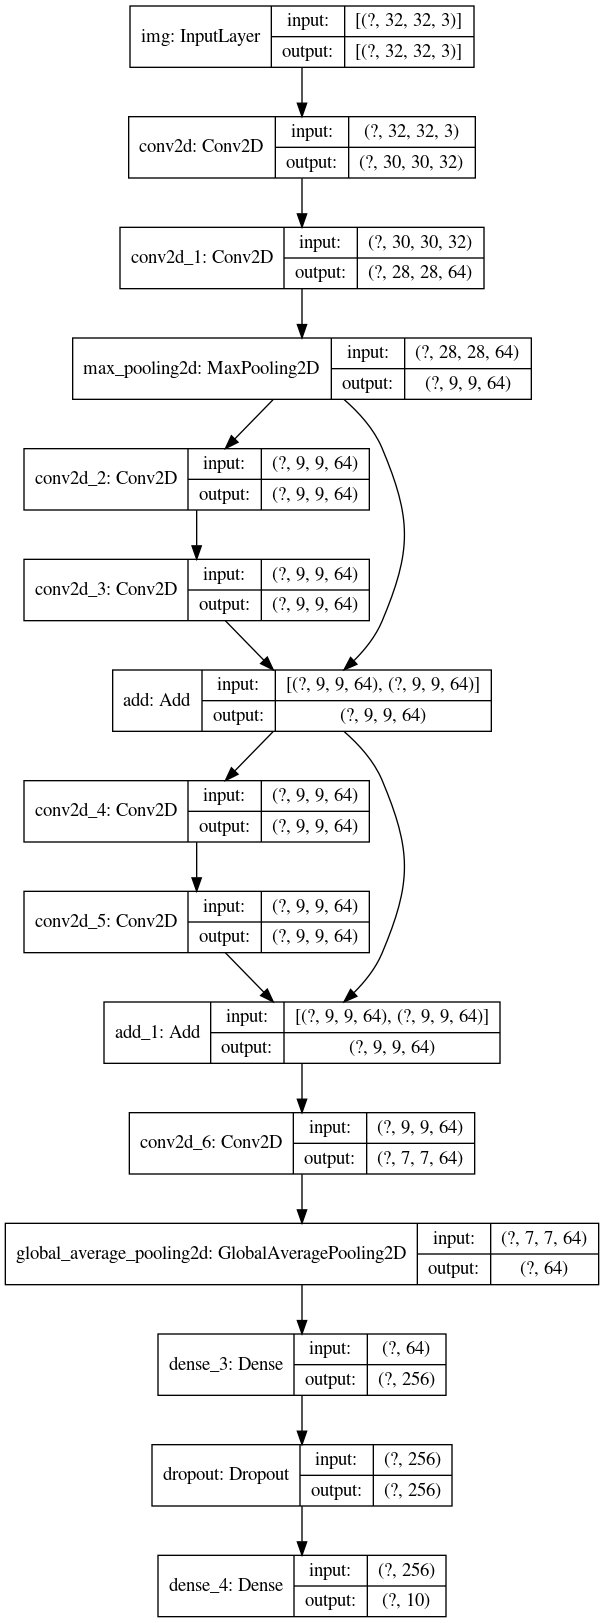

In [13]:
keras.utils.plot_model(model, "mini_resnet.png", show_shapes=True)

# Custom Layers / Models (subclassing)

 - call method, that specifies the computation done by the layer.
 - build method, that creates the weights of the layer (this is just a style convention since you can create weights in __init__, as well).

In [ ]:
class CustomDense(keras.Model):
    def __init__(self, units=32):
        super(CustomDense, self).__init__()
        self.units = units

    # creates the weights of the layer
    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    # É o que ele faz
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b


inputs = keras.Input((4,))
outputs = CustomDense(10)(inputs)

model = keras.Model(inputs, outputs)

In [ ]:
class MLP(keras.Model):

  def __init__(self, **kwargs):
    super(MLP, self).__init__(**kwargs)
    self.dense_1 = layers.Dense(64, activation='relu')
    self.dense_2 = layers.Dense(10)

  def call(self, inputs):
    x = self.dense_1(inputs)
    return self.dense_2(x)

# Instantiate the model.
mlp = MLP()
# Necessary to create the model's state.
# The model doesn't have a state until it's called at least once.
_ = mlp(tf.zeros((1, 32)))

# Além disso ...

In [ ]:
class CustomMSE(keras.losses.Loss):
    pass

class CategoricalTruePositives(keras.metrics.Metric):
    pass

class CIFAR10Sequence(Sequence):
    pass